# Clustering Models

In [55]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import dtale
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D


In [107]:
file = open('data.p', 'rb')
df = pickle.load(file)
file.close()

In [108]:
df.head()

,source,protest,econ,poli,gov,protest_mention,econ_mention,poli_mention,gov_mention,total_sentences,w_protest,w_econ,w_gov,w_poli,hl_sent,protest_ratio,econ_ratio,poli_ratio,gov_ratio
0,SCMP,0.97,0.00,0.62,1.14,1,0,1,2,4,0.242500,0.000000,0.57,0.155000,0.2960,0.250000,0.000000,0.250000,0.500000
1,SCMP,1.78,0.53,0.77,0.00,4,1,1,0,6,1.186667,0.088333,0.00,0.128333,0.7351,0.666667,0.166667,0.166667,0.000000
2,SCMP,2.13,0.00,1.57,0.00,4,0,2,0,6,1.420000,0.000000,0.00,0.523333,0.6249,0.666667,0.000000,0.333333,0.000000
3,SCMP,0.28,1.13,0.00,0.00,1,4,0,0,5,0.056000,0.904000,0.00,0.000000,0.4588,0.200000,0.800000,0.000000,0.000000
4,SCMP,1.04,0.00,0.80,1.19,3,0,1,3,7,0.445714,0.000000,0.51,0.114286,0.8979,0.428571,0.000000,0.142857,0.428571


In [81]:
# Convert source category to int: 0 - SCMP, 1 - ABC (Australia), 2 - Reuters, 3 - CCTV, 4 - CNN
# cond = [df['source'] == 'SCMP',
#         df['source'] == 'ABC (Australia)',
#         df['source'] == 'Reuters',
#         df['source'] == 'CCTV',
#         df['source'] == 'CNN']
# choice = [0, 1, 2, 3, 4]
# df['source'] = np.select(cond, choice)

In [ ]:
# df = df.loc[(df['source'] == 1)|(df['source'] == 3)|(df['source'] == 4)]

In [ ]:
# df['source'] = df['source'].astype('category')

In [109]:
X = df.drop(columns='source')
y = df['source']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [111]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [112]:
pca_1 = PCA(n_components=6)
pca_2 = PCA(n_components=7)
pca_3 = PCA(n_components=8)

principalComponents = pca_1.fit_transform(X_train)
principalComponents = pca_2.fit_transform(X_train)
principalComponents = pca_3.fit_transform(X_train)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))


0.958267444271461
0.9691076330798856
0.9778928355962565


In [113]:
pca = PCA(n_components=6)
comp = pca.fit_transform(X_train)

In [114]:
X_array = np.concatenate((comp, np.array(y_train).reshape(1072, 1)), axis=1)

In [115]:
comp_df = pd.DataFrame(data = X_array, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'source'])

In [116]:
comp_df['source'] = comp_df['source'].astype('category')

In [117]:
X1 = comp_df.drop(columns='source')
y1 = comp_df['source']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# pca = PCA(n_components=3)
# comp_train = pca.fit_transform(X_train)
# comp_test = pca.transform(X_test)

In [ ]:
# X = df.iloc[:, 1:5].values
# y = df['source']

In [ ]:
# comp_train_df = pd.DataFrame(data = comp_train, columns = ['pc1', 'pc2', 'pc3'])
# comp_test_df = pd.DataFrame(data = comp_test, columns = ['pc1', 'pc2', 'pc3'])

In [ ]:
# X1 = comp_train_df.values

/Users/waynelam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



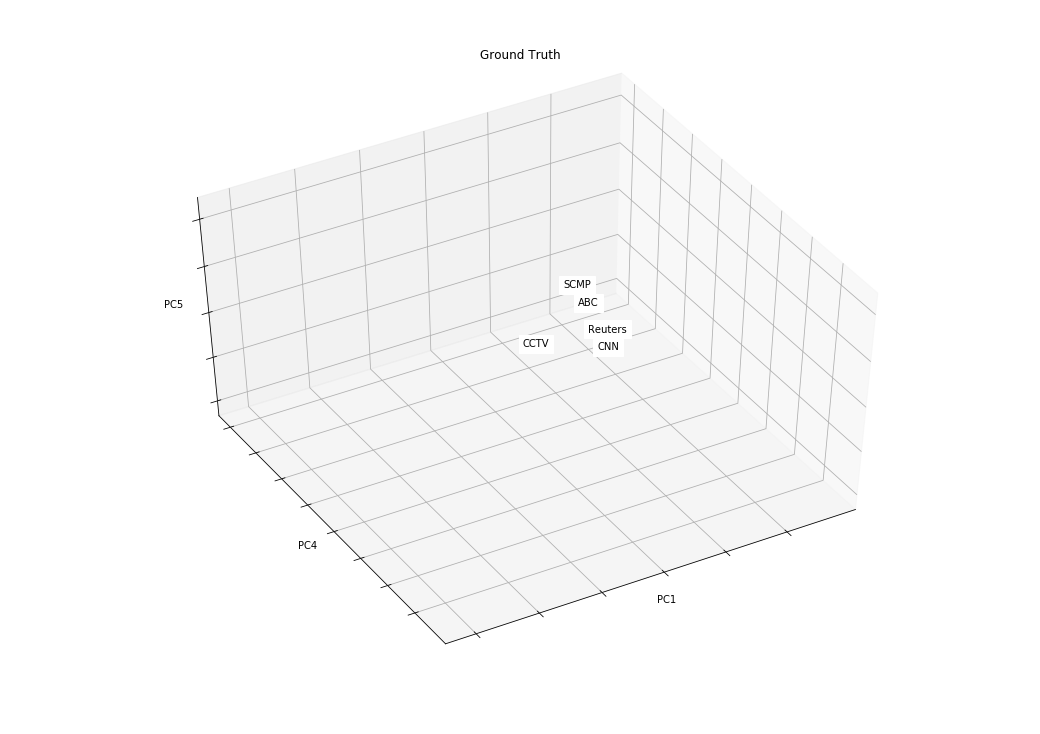

In [95]:
# estimators = [('k_means_top_senti_2', KMeans(n_clusters=2)),
#               ('k_means_top_senti_3', KMeans(n_clusters=3)),
#               ('k_means_top_senti_5', KMeans(n_clusters=5))]

# fignum = 1
# titles = ['2 clusters', '3 clusters', '5 clusters']
# for name, est in estimators:
#     fig = plt.figure(fignum, figsize=(15, 10))
#     ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=60)
#     est.fit(X_array)
#     labels = est.labels_

#     ax.scatter(X_array[:, 0], X_array[:, 3], X_array[:, 4],
#                c=labels.astype(np.float), edgecolor='k')

#     ax.w_xaxis.set_ticklabels([])
#     ax.w_yaxis.set_ticklabels([])
#     ax.w_zaxis.set_ticklabels([])
#     ax.set_xlabel('PC1')
#     ax.set_ylabel('PC2')
#     ax.set_zlabel('PC3')
#     ax.set_title(titles[fignum - 1])
#     ax.dist = 12
#     fignum = fignum + 1

# # # Plot the ground truth
# fig = plt.figure(fignum, figsize=(15, 10))
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=50, azim=60)

# for name, label in [('SCMP', 0),
#                     ('ABC', 1),
#                     ('Reuters', 2),
#                     ('CCTV', 3),
#                     ('CNN', 4)]:
#     ax.text3D(X_array[y1 == label, 0].mean(),
#               X_array[y1 == label, 3].mean(),
#               X_array[y1 == label, 4].mean(), name,
#               horizontalalignment='center',
#               bbox=dict(alpha=1, edgecolor='w', facecolor='w'))
# # Reorder the labels to have colors matching the cluster results
# # y = np.choose(y, [1, 3, 4])
# ax.scatter(X_array[:, 0], X_array[:, 3], X_array[:, 4], c=y1, edgecolor='k', alpha=0)

# ax.w_xaxis.set_ticklabels([])
# ax.w_yaxis.set_ticklabels([])
# ax.w_zaxis.set_ticklabels([])
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC4')
# ax.set_zlabel('PC5')
# ax.set_title('Ground Truth')
# ax.dist = 12

# fig.show()

In [118]:
cond1 = (comp_df['source'] == 'CCTV')
cond2 = (comp_df['source'] == 'CNN')
cond3 = (comp_df['source'] == 'ABC (Australia)')
cond4 = (comp_df['source'] == 'SCMP')
cond5 = (comp_df['source'] == 'Reuters')

In [119]:
plot_df = comp_df.loc[cond1|cond4|cond3]

In [120]:
plot_df

,pc1,pc2,pc3,pc4,pc5,pc6,source
0,-0.298181,0.439789,0.142809,-1.72591,-0.306175,-0.254915,SCMP
1,2.43623,0.666363,0.627224,0.496814,-0.6293,-0.894746,CCTV
2,3.50507,0.345035,0.384124,-1.4818,-0.334201,0.505404,CCTV
4,-0.875868,-1.74793,-1.38588,-0.0741227,-0.421455,1.03623,SCMP
5,-1.33758,-1.05467,-0.881828,0.654402,0.146827,-0.713334,SCMP
...,...,...,...,...,...,...,...
1061,-1.94833,1.77957,-0.525423,-1.04265,-0.122358,0.221859,SCMP
1063,11.6,5.15767,0.437971,0.653409,0.888998,-0.386793,CCTV
1065,-2.24138,1.10308,0.410412,-1.38136,0.761267,-0.707066,SCMP
1066,2.73862,-1.18854,2.6302,-0.331961,-1.06278,-0.402991,CCTV


In [121]:
color_map = {'CCTV': 'red', 'SCMP': 'darkslategrey', 'ABC (Australia)': 'khaki'}
fig = px.scatter_3d(plot_df, x='pc1', y='pc3', z='pc5', color='source', color_discrete_map=color_map)
fig.show()

Executing shutdown due to inactivity...


2020-04-08 23:13:10,822 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2020-04-08 23:13:10,842 - INFO     - Executing shutdown...


In [105]:
comp_df

,pc1,pc2,pc3,pc4,pc5,pc6,source
0,-0.298181,0.439789,0.142809,-1.725907,-0.306175,-0.254915,0.0
1,2.436232,0.666363,0.627224,0.496814,-0.629300,-0.894746,3.0
2,3.505073,0.345035,0.384124,-1.481805,-0.334201,0.505404,3.0
3,0.977717,-1.821650,1.249370,-0.056504,-0.798751,-0.872673,2.0
4,-0.875868,-1.747925,-1.385880,-0.074123,-0.421455,1.036233,0.0
...,...,...,...,...,...,...,...
1067,-0.336166,-1.010262,-2.562126,1.090755,-0.492239,-0.819836,2.0
1068,-0.246461,-1.783270,-3.732693,3.118177,0.296577,-0.213960,2.0
1069,0.705495,-0.015293,-0.980913,0.145594,-0.699318,-0.892068,1.0
1070,-1.966077,0.996215,-0.632859,-2.390633,0.100184,1.213376,2.0
